In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../../data/양파요약데이터_직팜정리.csv', encoding='cp949')

In [ ]:
df['총가격(원)'] =  df['총금액(원)']
df['단위총물량(kg)'] = df['총거래량(kg)']
df['상품 중분류 이름'] = df['품목명']
df.sample()

In [5]:
df['날짜(YYYY-MM-DD)'] = pd.to_datetime(df['날짜(YYYY-MM-DD)'])

# 연도, 월, 일 컬럼 생성
df['연도'] = df['날짜(YYYY-MM-DD)'].dt.year
df['월'] = df['날짜(YYYY-MM-DD)'].dt.month
df['일'] = df['날짜(YYYY-MM-DD)'].dt.day

# 결과 확인
df.sample()

,날짜(YYYY-MM-DD),상품 중분류 이름,등급이름,총가격(원),단위총물량(kg),산지코드,산지이름,직팜산지코드,직팜산지이름,연도,월,일
944599,2024-06-18,양파,하,1215500.0,2040.0,534000,전라남도 무안군,1097,전라남도 무안군,2024,6,18


In [148]:
df[df['직팜산지코드']==1161]
df.drop(df[df['직팜산지코드']==1161].index, inplace=True)

In [6]:
import pandas as pd
import numpy as np

def get_week_of_year(date):
    year = date.year
    week_number = date.isocalendar().week
    return f"{year}년 {week_number}째주"

def split_to_week(df):
    temp_df = df.copy()
    
    temp_df['단가'] = round(temp_df['총가격(원)'] / temp_df['단위총물량(kg)'])
    temp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    temp_df.dropna(subset=['단가'], inplace=True)

    temp_df['날짜(YYYY-MM-DD)'] = pd.to_datetime(temp_df['날짜(YYYY-MM-DD)'])
    temp_df.set_index('날짜(YYYY-MM-DD)', inplace=True)
    weekly_df = temp_df.groupby(['상품 중분류 이름']).resample('W').agg({'단가': 'mean'}).reset_index()
    weekly_df['단가'] = weekly_df['단가'].astype(float)
    weekly_df.rename(columns={'날짜(YYYY-MM-DD)': '날짜'}, inplace=True)


    weekly_df['날짜'] = weekly_df['날짜'].apply(get_week_of_year)

    return weekly_df

In [8]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
# 한글설정
plt.rc('font', family='Malgun Gothic') # 윈도우즈

In [12]:
weekly_df = split_to_week(df)

# 수치형 데이터의 분포
- 데이터의 집중 구간: 데이터가 어느 값대에 가장 많이 모여 있는지 알 수 있음
- 분포의 모양: 데이터가 대칭적인지, 한쪽으로 치우쳐 있는지(왜도), 봉우리가 하나인지 여러 개인지(첨도) 등을 시각적으로 확인할 수 있음
- 이상치(Outlier)의 존재 가능성: 분포의 양 끝단에 데이터가 드물게 나타나는지 등을 통해 이상치의 존재를 짐작할 수 있음

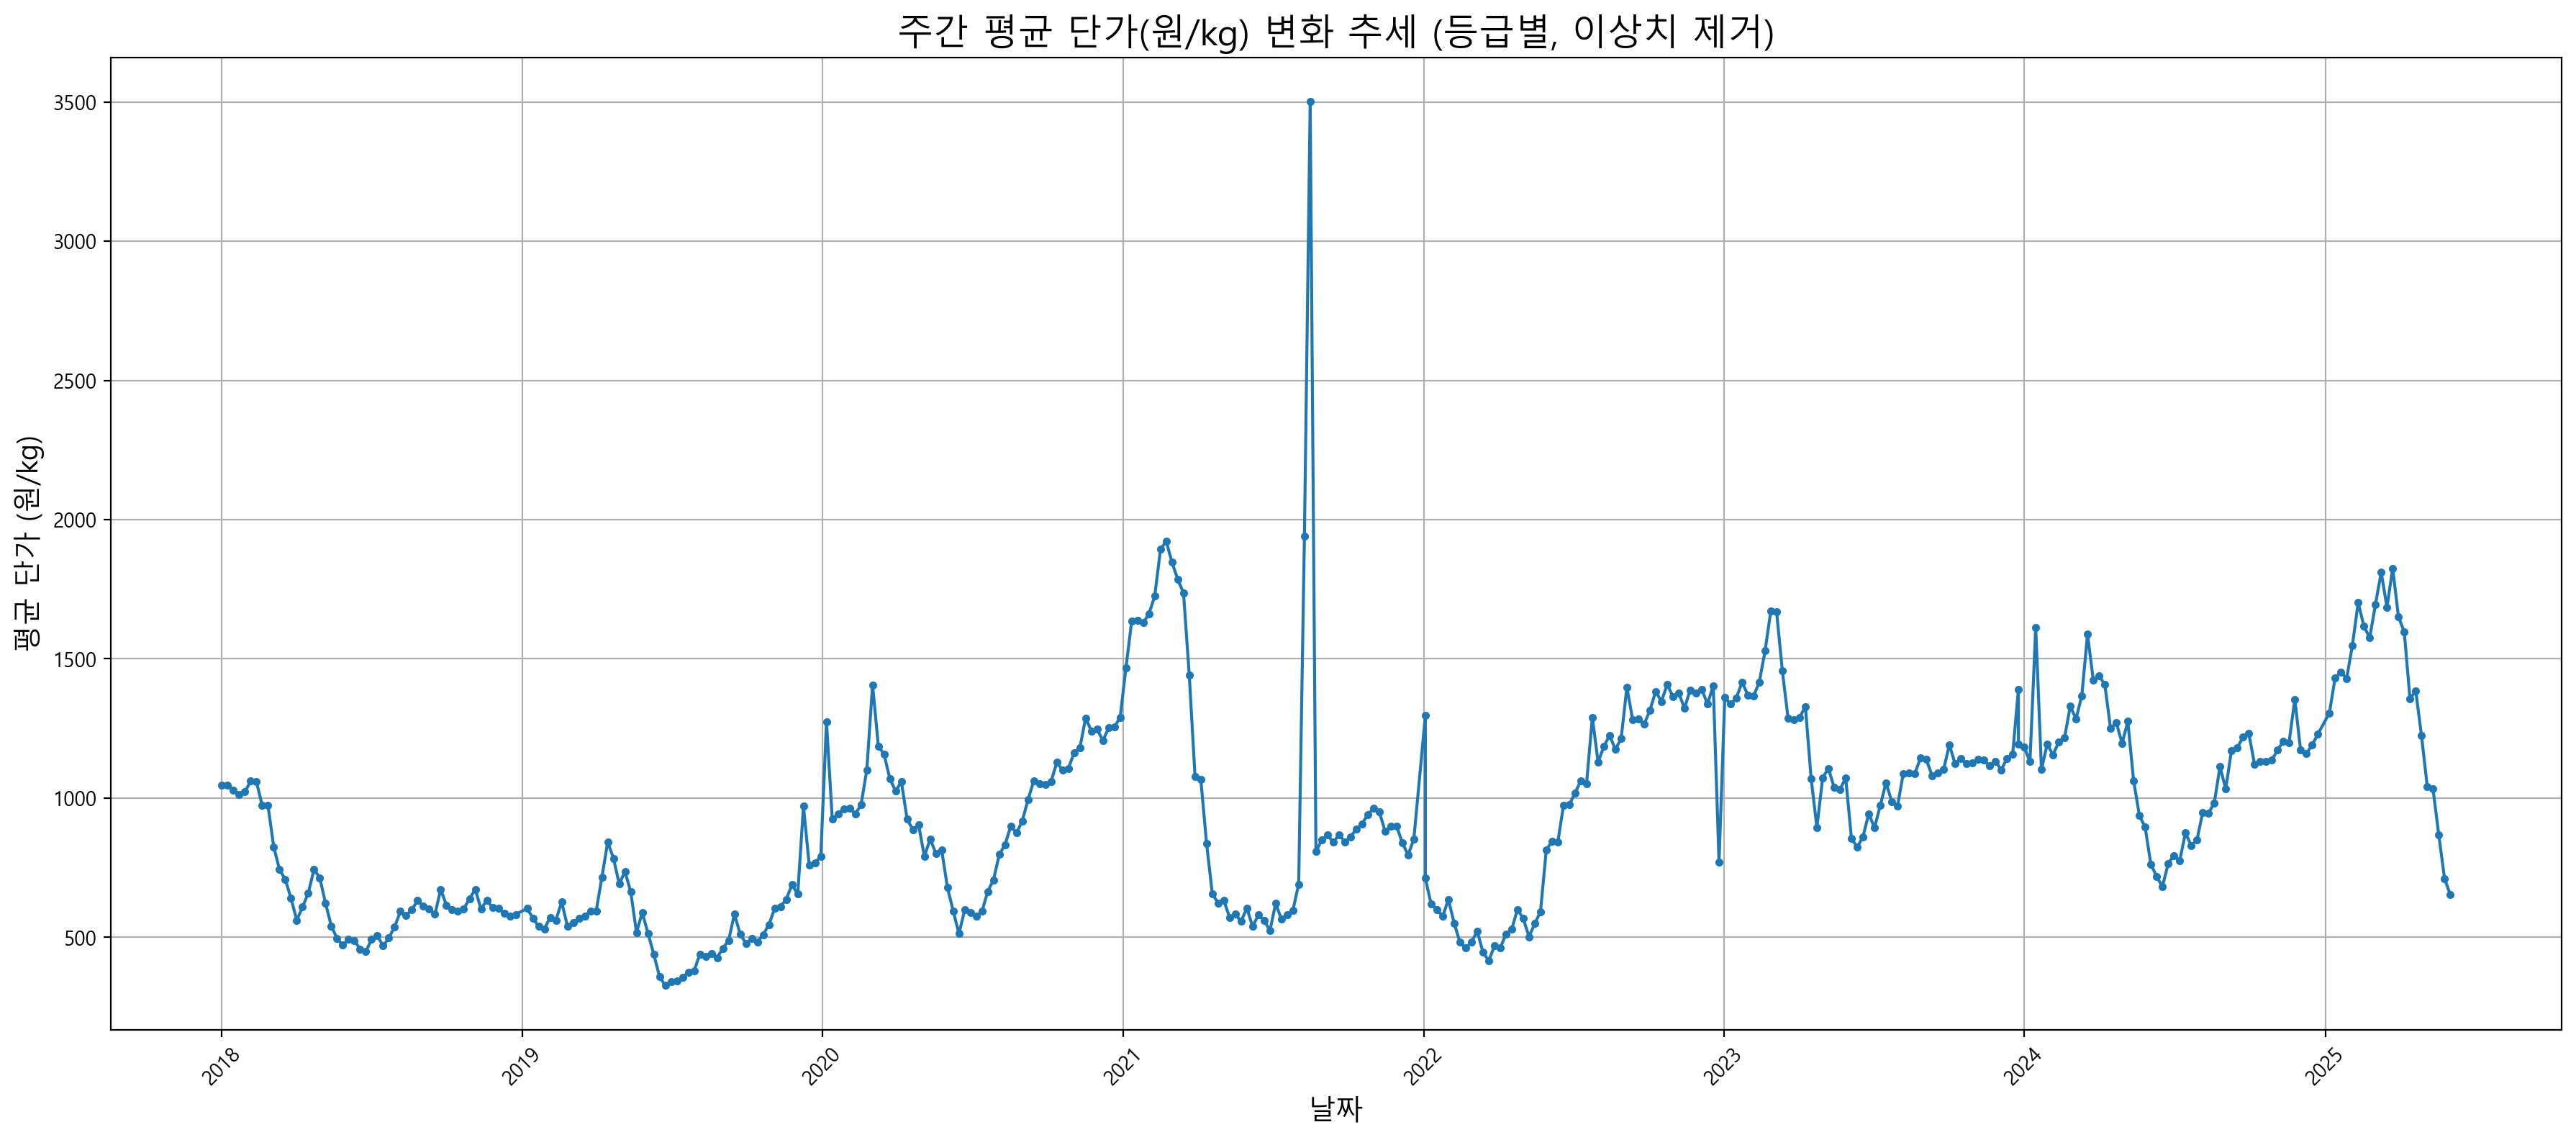

In [ ]:
def parse_week_string(week_str):
       year_str, week_num_str = week_str.replace('년 ', '-').replace('째주', '').split('-')
       year = int(year_str)
       week_num = int(week_num_str)
       # ISO 주차 시스템을 사용하여 해당 주의 첫째 날 (월요일)을 계산합니다.
       return pd.to_datetime(f'{year}-W{week_num}-1', format='%Y-W%W-%w')

weekly_df['날짜_dt'] = weekly_df['날짜'].apply(parse_week_string)
weakly_df = weekly_df.sort_values('날짜_dt')

Q1 = weekly_df['단가'].quantile(0.25)
Q3 = weekly_df['단가'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
weekly_df = weekly_df[(weekly_df['단가'] >= lower_bound) & (weekly_df['단가'] <= upper_bound)]

# --- 그래프 그리기 ---
plt.figure(figsize=(18, 8)) # 그래프 크기를 더 크게 설정

plt.plot(weakly_df['날짜_dt'], weakly_df['단가'], marker='.', linestyle='-',)

plt.title('주간 평균 단가(원/kg) 변화 추세 (등급별, 이상치 제거)', fontsize=18)
plt.xlabel('날짜', fontsize=14)
plt.ylabel('평균 단가 (원/kg)', fontsize=14)
plt.grid(True)

plt.xticks(rotation=45) 

plt.tight_layout() 
plt.show()

In [14]:
df

,날짜(YYYY-MM-DD),상품 중분류 이름,등급이름,총가격(원),단위총물량(kg),산지코드,산지이름,직팜산지코드,직팜산지이름,연도,월,일
0,2018-01-03,양파,특,4893000.0,4200.0,676000,경상남도 함양군,1139,경상남도 함양군,2018,1,3
1,2018-01-03,양파,특,13500000.0,15000.0,157740,서울 강서구 외발산동 강서농산물시장,1000,서울특별시,2018,1,3
2,2018-01-03,양파,상,3976000.0,4200.0,676000,경상남도 함양군,1139,경상남도 함양군,2018,1,3
3,2018-01-03,양파,보통,1610000.0,2100.0,676000,경상남도 함양군,1139,경상남도 함양군,2018,1,3
4,2018-01-03,양파,보통,1860000.0,2400.0,676000,경상남도 함양군,1139,경상남도 함양군,2018,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
988275,2024-11-29,양파,특,1846400.0,1620.0,390011,충북 제천시 중앙로1가,1047,충청북도 제천시,2024,11,29
988276,2024-11-29,양파,보통,220400.0,285.0,390011,충북 제천시 중앙로1가,1047,충청북도 제천시,2024,11,29
988277,2024-11-29,양파,하,748000.0,825.0,390011,충북 제천시 중앙로1가,1047,충청북도 제천시,2024,11,29
988278,2024-11-29,양파,특,50400.0,45.0,138701,서울 송파구 가락1동 가락농수산물시장,1000,서울특별시,2024,11,29


모델 학습 중...
학습 완료!


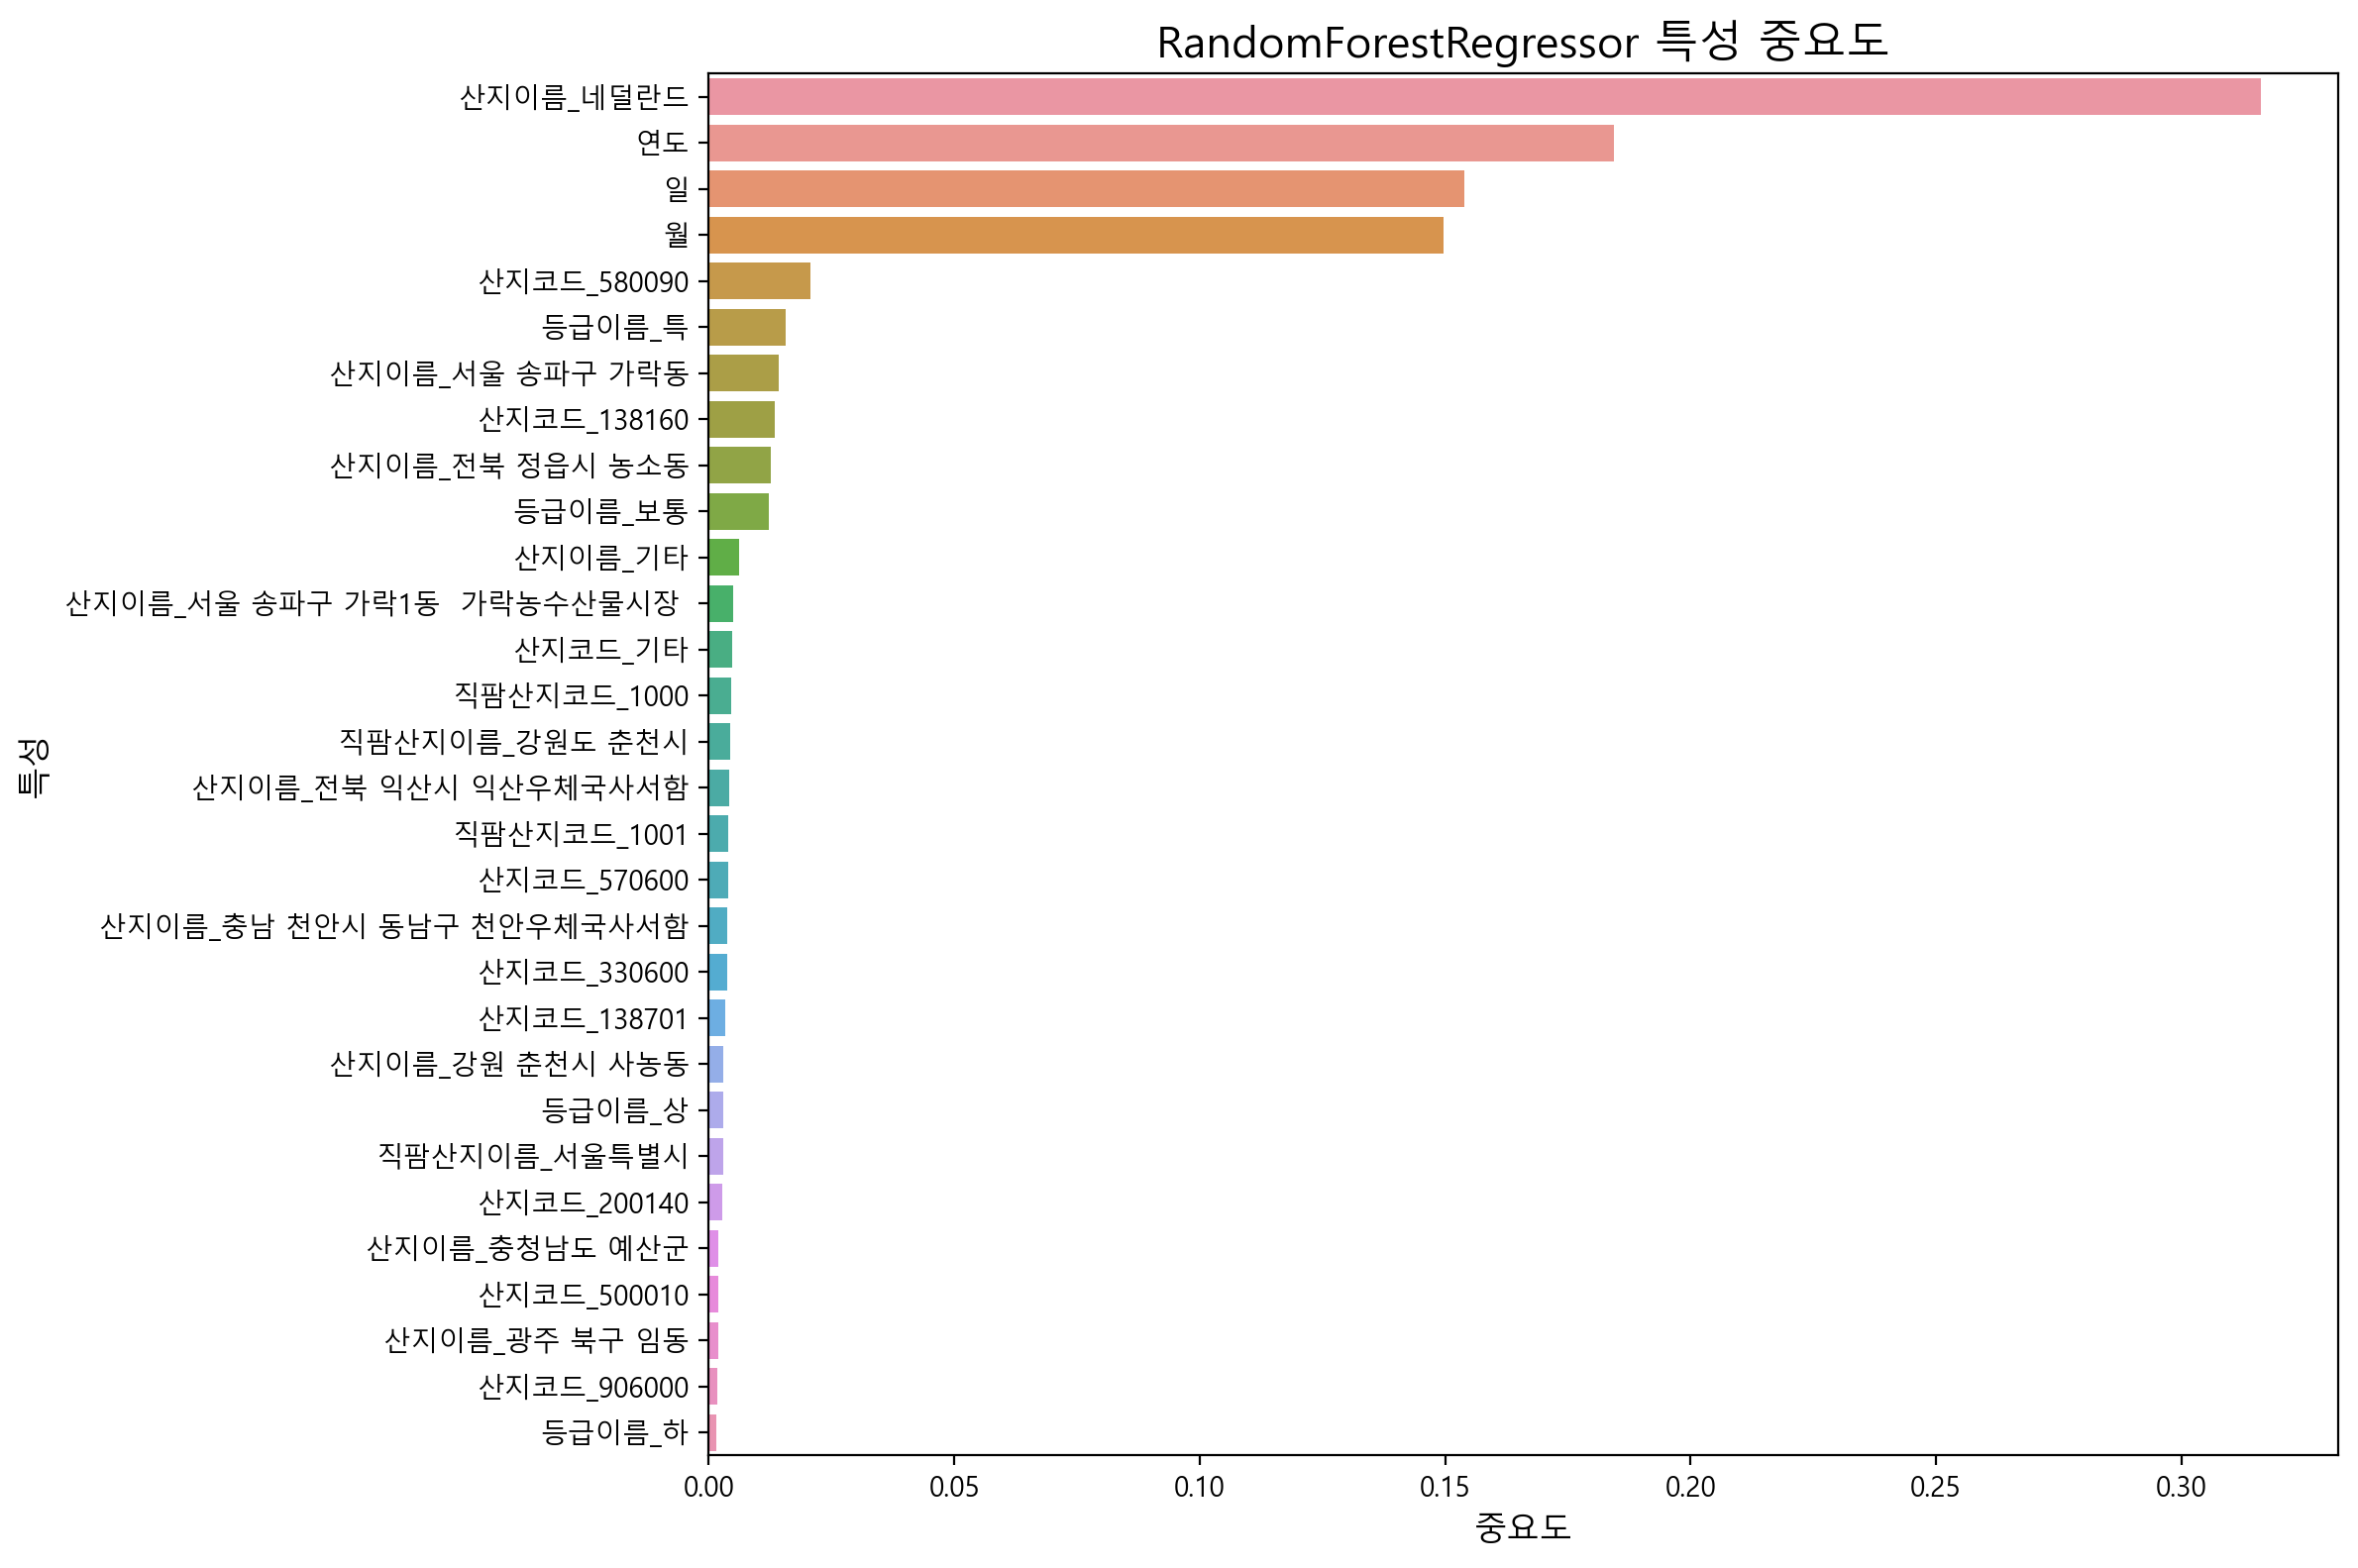


--- 특성 중요도 상위 10개 ---
              Feature  Importance
405         산지이름_네덜란드    0.316140
2068               연도    0.184352
2070                일    0.153927
2069                월    0.149738
1472      산지코드_580090    0.020650
2              등급이름_특    0.015628
466   산지이름_서울 송파구 가락동    0.014271
1041      산지코드_138160    0.013440
757   산지이름_전북 정읍시 농소동    0.012667
0             등급이름_보통    0.012219


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 한글 설정 (윈도우 기준)
plt.rc('font', family='Malgun Gothic')
%config InlineBackend.figure_format = 'retina'

# --- 데이터 로딩 ---
df = pd.read_csv('../../data/유통공사_도매시장_사과_20200101-20225701.csv', encoding='cp949')

# --- 단가 생성 ---
if '단가' not in df.columns:
    volume_col = '단위총물량(kg)'
    price_col = '총가격(원)'
    df = df[df[volume_col] > 0].copy()
    df['단가'] = df[price_col] / df[volume_col]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['단가'], inplace=True)

# --- 날짜 전처리 ---
date_col = '날짜(YYYY-MM-DD)'
if date_col in df.columns and not pd.api.types.is_datetime64_any_dtype(df[date_col]):
    df[date_col] = pd.to_datetime(df[date_col])
    df['연도'] = df[date_col].dt.year
    df['월'] = df[date_col].dt.month
    df['일'] = df[date_col].dt.day

# --- 희귀 카테고리 통합 함수 ---
def collapse_rare_categories(series, min_count):
    vc = series.value_counts()
    return series.where(series.isin(vc[vc >= min_count].index), other='기타')

# --- 희귀 카테고리 통합 적용 ---
threshold = 50
for col in ['산지이름', '직팜산지이름', '산지코드', '직팜산지코드']:
    df[col] = collapse_rare_categories(df[col].astype(str), min_count=threshold)

df['산지코드'] = df['산지코드'].astype(str)
df['직팜산지코드'] = df['직팜산지코드'].astype(str)

# --- 모델용 데이터 구성 ---
# 독립변수 추가할 때 여기서 추가하기
features = [
    '등급이름', '산지이름', '직팜산지이름', '산지코드', '직팜산지코드',
    '연도', '월', '일'
]
target = '단가'

df_model = df[features + [target]].dropna()

# --- 샘플링 (선택, 속도 개선용) ---
df_model = df_model.sample(30000, random_state=42)

X = df_model[features]
y = df_model[target]

# --- 범주형/수치형 분리 ---
categorical_features = ['등급이름', '산지이름', '직팜산지이름','산지코드','직팜산지코드']
numerical_features = ['연도', '월', '일']

# --- 전처리 및 파이프라인 ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100, max_depth=15, n_jobs=-1, random_state=42
    ))
])

# --- 학습 ---
print("모델 학습 중...")
model_pipeline.fit(X, y)
print("학습 완료!")

# --- 특성 중요도 추출 및 시각화 ---
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(ohe_feature_names) + numerical_features

importances = model_pipeline.named_steps['regressor'].feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- 시각화 ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(30))  # 상위 30개만
plt.title('RandomForestRegressor 특성 중요도', fontsize=16)
plt.xlabel('중요도', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.tight_layout()
plt.show()

print("\n--- 특성 중요도 상위 10개 ---")
print(feature_importances_df.head(10))


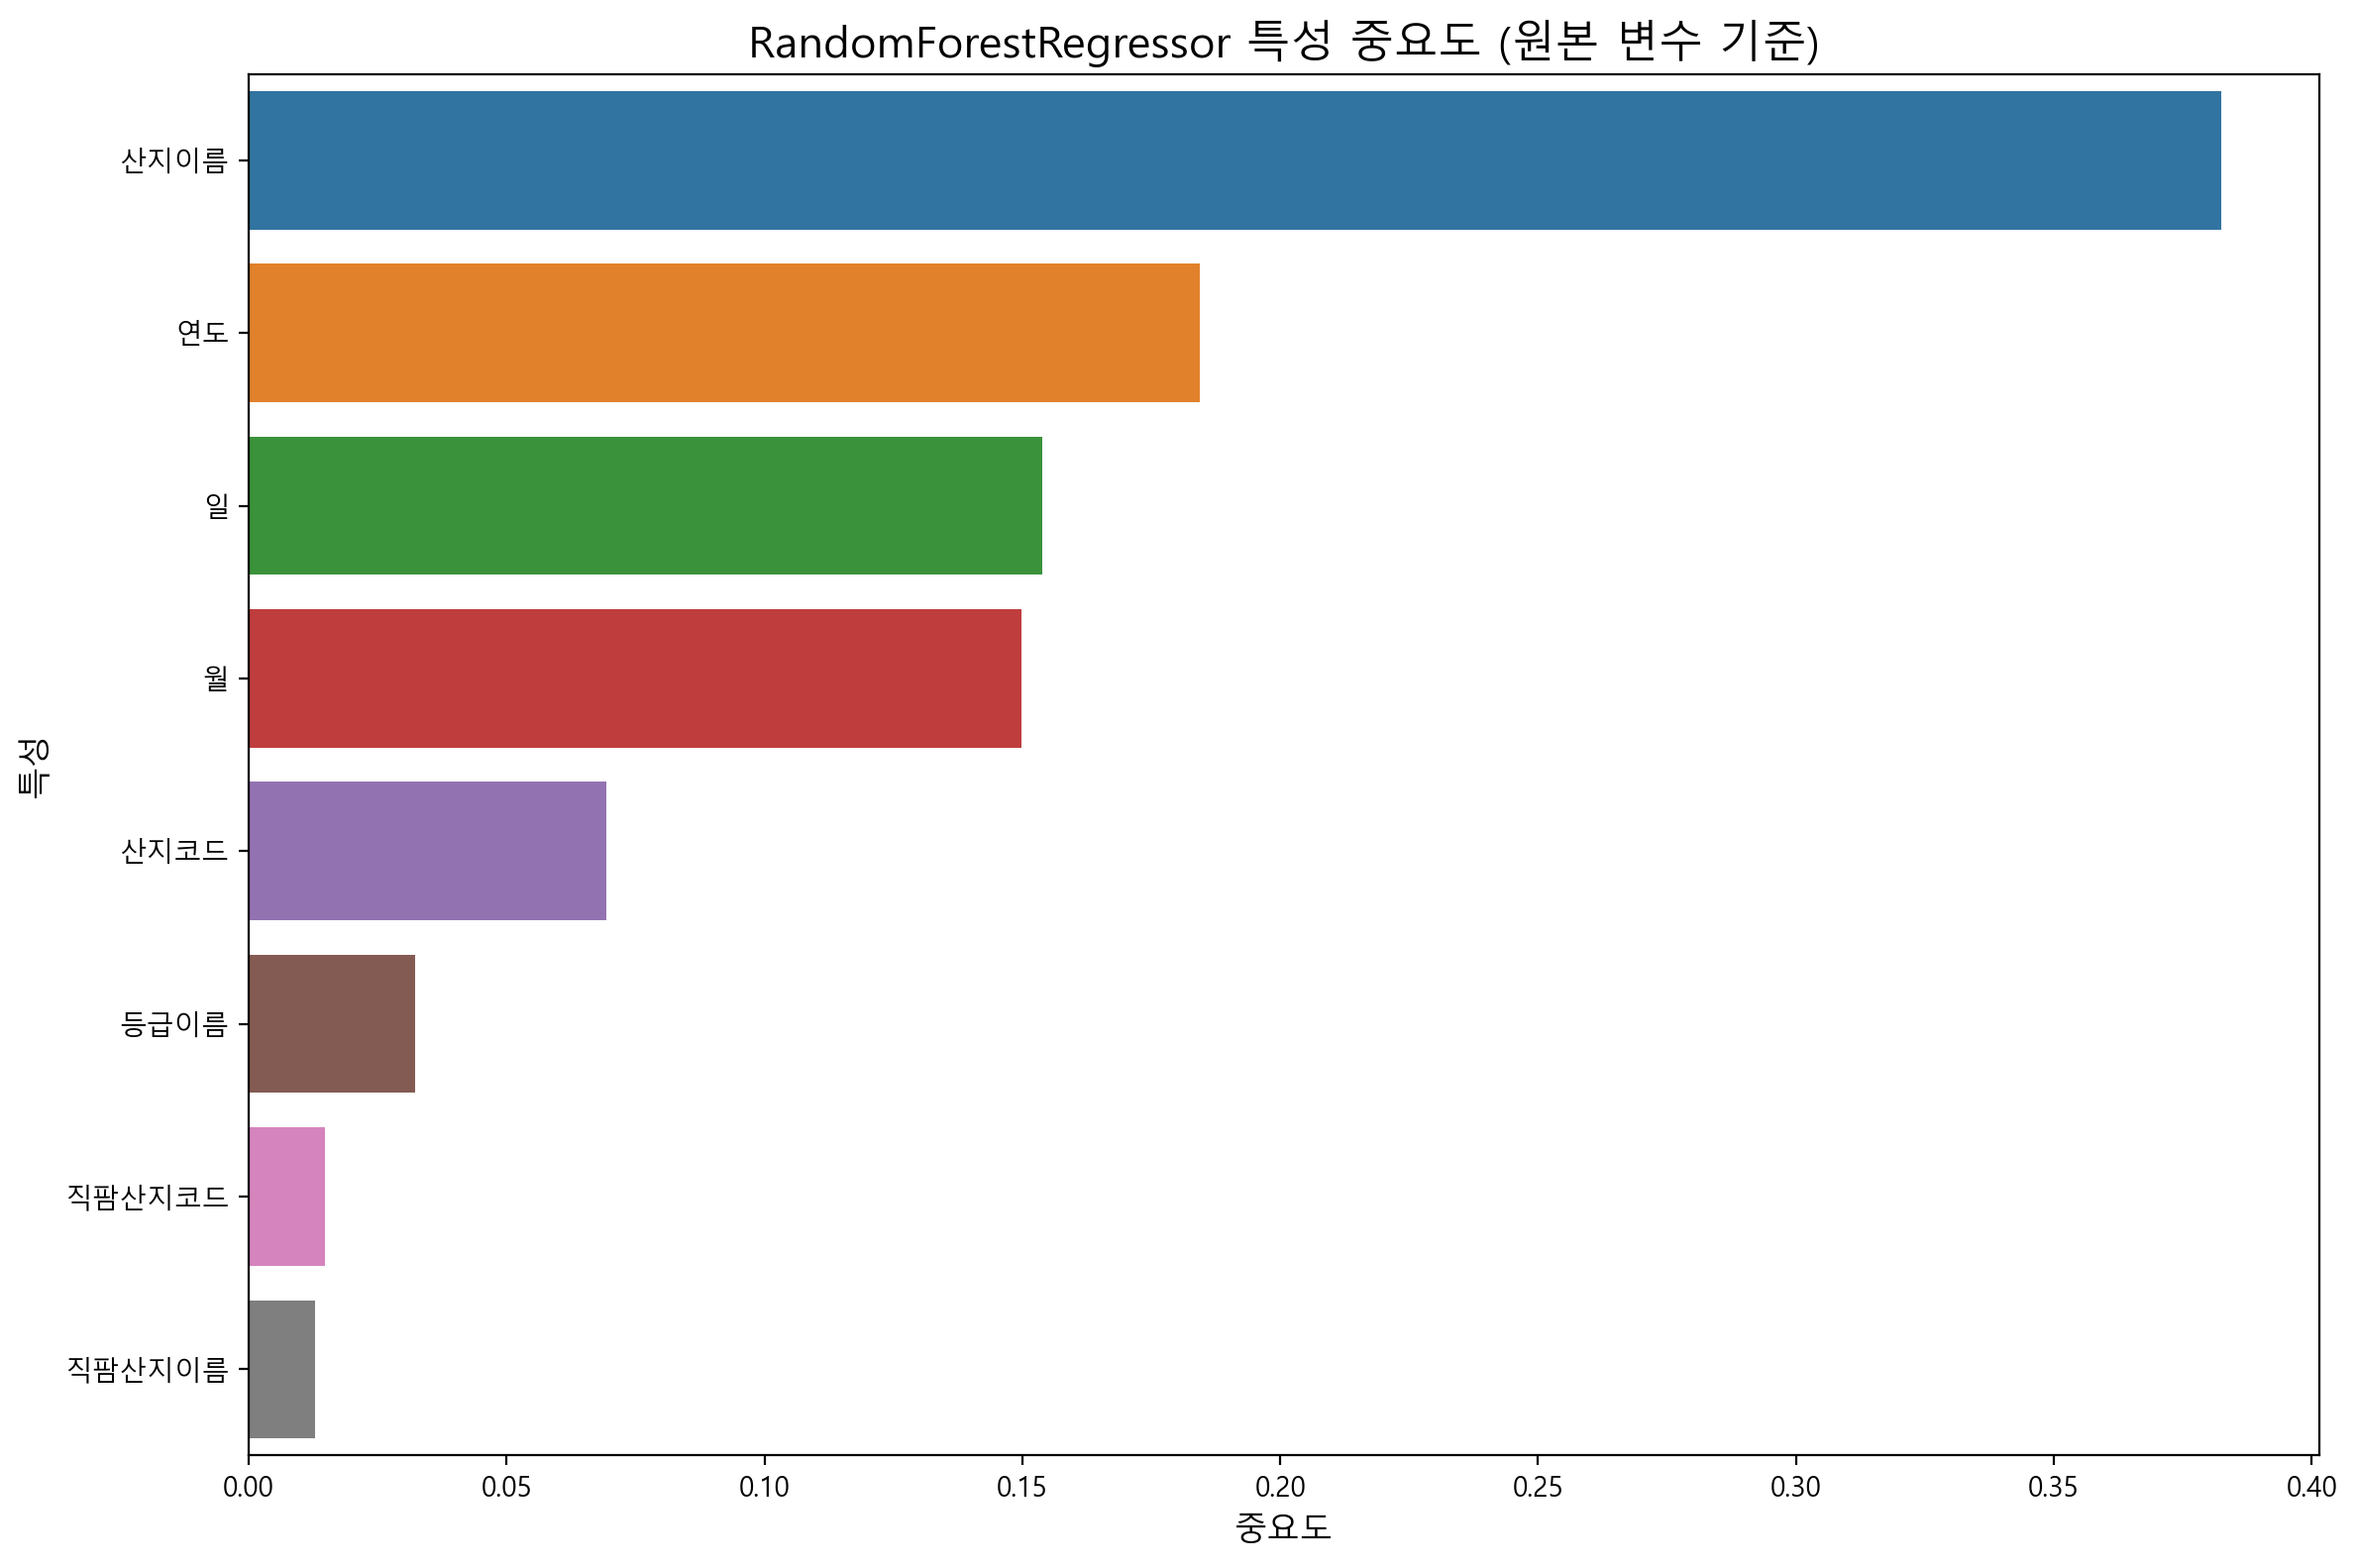


--- 특성 중요도 (원본 변수 기준) ---
  Feature  Importance
1    산지이름    0.382463
5      연도    0.184352
7       일    0.153927
6       월    0.149738
3    산지코드    0.069431
0    등급이름    0.032358
4  직팜산지코드    0.014848
2  직팜산지이름    0.012884


In [176]:
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(ohe_feature_names) + numerical_features

importances = model_pipeline.named_steps['regressor'].feature_importances_

# 특성 중요도를 데이터프레임으로 만듭니다.
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# 원본 범주형 변수별 중요도를 합산하기 위한 딕셔너리
aggregated_importances = {}

# 범주형 특성들의 중요도를 합산합니다.
for original_cat_feature in categorical_features:
    # 해당 원본 범주형 특성으로 시작하는 모든 원-핫 인코딩된 특성들을 찾습니다.
    # 예: '산지이름_네덜란드', '산지이름_서울 송파구 가락동' 등
    matching_features = [f for f in feature_importances_df['Feature'] if f.startswith(original_cat_feature + '_')]

    if matching_features:
        # 해당 특성들의 중요도를 합산합니다.
        summed_importance = feature_importances_df[feature_importances_df['Feature'].isin(matching_features)]['Importance'].sum()
        aggregated_importances[original_cat_feature] = summed_importance
    else:
        # 만약 해당 범주형 특성이 원-핫 인코딩 후 아무것도 남지 않았다면 (예: 모두 '기타'로 통합된 경우)
        # 또는 해당 특성이 원래부터 없었다면 0으로 처리
        aggregated_importances[original_cat_feature] = 0

# 수치형 특성들의 중요도를 추가합니다.
for num_feature in numerical_features:
    # 수치형 특성은 이름이 그대로이므로 직접 찾아서 추가합니다.
    importance = feature_importances_df[feature_importances_df['Feature'] == num_feature]['Importance'].iloc[0]
    aggregated_importances[num_feature] = importance

# 합산된 중요도를 새로운 데이터프레임으로 만듭니다.
final_importances_df = pd.DataFrame(
    list(aggregated_importances.items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# --- 시각화 ---
plt.figure(figsize=(12, 8))
# 이제 상위 30개가 아닌, 모든 원본 특성들을 보여줍니다.
sns.barplot(x='Importance', y='Feature', data=final_importances_df)
plt.title('RandomForestRegressor 특성 중요도 (원본 변수 기준)', fontsize=16)
plt.xlabel('중요도', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.tight_layout()
plt.show()

print("\n--- 특성 중요도 (원본 변수 기준) ---")
print(final_importances_df)

In [ ]:
df

,날짜(YYYY-MM-DD),상품 중분류 이름,등급이름,총가격(원),단위총물량(kg),산지코드,산지이름,직팜산지코드,직팜산지이름,단가,연도,월,일
0,2018-01-03,양파,특,4893000.0,4200.0,676000,경상남도 함양군,1139,경상남도 함양군,1165.000000,2018,1,3
1,2018-01-03,양파,특,13500000.0,15000.0,157740,서울 강서구 외발산동 강서농산물시장,1000,서울특별시,900.000000,2018,1,3
2,2018-01-03,양파,상,3976000.0,4200.0,676000,경상남도 함양군,1139,경상남도 함양군,946.666667,2018,1,3
3,2018-01-03,양파,보통,1610000.0,2100.0,676000,경상남도 함양군,1139,경상남도 함양군,766.666667,2018,1,3
4,2018-01-03,양파,보통,1860000.0,2400.0,676000,경상남도 함양군,1139,경상남도 함양군,775.000000,2018,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
988275,2024-11-29,양파,특,1846400.0,1620.0,390011,충북 제천시 중앙로1가,1047,충청북도 제천시,1139.753086,2024,11,29
988276,2024-11-29,양파,보통,220400.0,285.0,390011,충북 제천시 중앙로1가,1047,충청북도 제천시,773.333333,2024,11,29
988277,2024-11-29,양파,하,748000.0,825.0,390011,충북 제천시 중앙로1가,1047,충청북도 제천시,906.666667,2024,11,29
988278,2024-11-29,양파,특,50400.0,45.0,138701,서울 송파구 가락1동 가락농수산물시장,1000,서울특별시,1120.000000,2024,11,29
